# Image Classification of ATLAS Calorimeter Topo-Clusters Rewrite

Quick Navigation:
- [Simple feed-forward Neural Network](#Simple-feed-forward-Neural-Network)
- [ROC Curve Scans](#ROC-Curve-Scans)
- [Combination Network](#Combination-Network)
- [Convolutional Neural Network](#Convolutional-Neural-Network)
- [Correlation Plots](#Correlation-Plots)

First, let's make sure that we have `latex` set up correctly. 

We will need this for the `atlas_mpl_style` package, which is used throughout some of ML4Pion's pre-existing utilities. As of October 22, 2020, the [UChicago ML platform](ml.maniac.uchicago.edu) does *not* have `latex` pre-installed. We can take care of this with our own installation script -- note that installed `latex` with `conda` [does not work well at the moment](https://github.com/conda-forge/texlive-core-feedstock/issues/19) so we fall back on the slower, regular method for installing `texlive` -- but we haven't made the necessary addition to our `$PATH` for `latex` so we must set it now locally for the notebook. (We avoid touching the `.bash_profile` on the ML platform or [making a custom Jupyter kernel](https://stackoverflow.com/a/53595397) for now.)

In [1]:
# Check if latex is set up already.
# We use some Jupyter magic -- alternatively one could use python's subprocess here.
has_latex = !command -v latex
has_latex = (not has_latex == [])

# If latex was not a recognized command, our setup script should have installed
# at a fixed location, but it is not on the $PATH. Now let's use some Jupyter magic.
# See https://ipython.readthedocs.io/en/stable/interactive/shell.html for info.
if(not has_latex):
    latex_prefix = '/usr/local/texlive/2020/bin/x86_64-linux'
    jupyter_env = %env
    path = jupyter_env['PATH']
    path = path + ':' + latex_prefix
    %env PATH = $path
    jupyter_env = %env
    path = jupyter_env['PATH']

env: PATH=/opt/conda/envs/ml4p/bin:/opt/conda/condabin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/texlive/2020/bin/x86_64-linux


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

path_prefix = '/workspace/LCStudies/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [4]:
# fancy display names for each pion type
pi_latex = {
    'pi0': '\(\pi^{0}\)',
    'piplus': '\(\pi^{+}\)',
    'piminus': '\(\pi^{-}\)',
}

In [5]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
sys.path
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

In [6]:
# import pi+- vs. pi0 images

inputpath = path_prefix+'data/'
#path = '/eos/user/m/mswiatlo/images/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
rootfiles = ["pi0", "piplus", "piminus"]
trees = {
    rfile : ur.open(inputpath+rfile+".root")['ClusterTree']
    for rfile in rootfiles
}
pdata = {
    ifile : itree.pandas.df(branches, flatten=False)
    for ifile, itree in trees.items()
}

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


Vectors in the root file have to be handled separately since pandas doesn't import them nicely

In [7]:
cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer)
        for layer in layers
    }
    for ifile, itree in trees.items()
}

### Plot a few example images.

<Figure size 576x432 with 0 Axes>

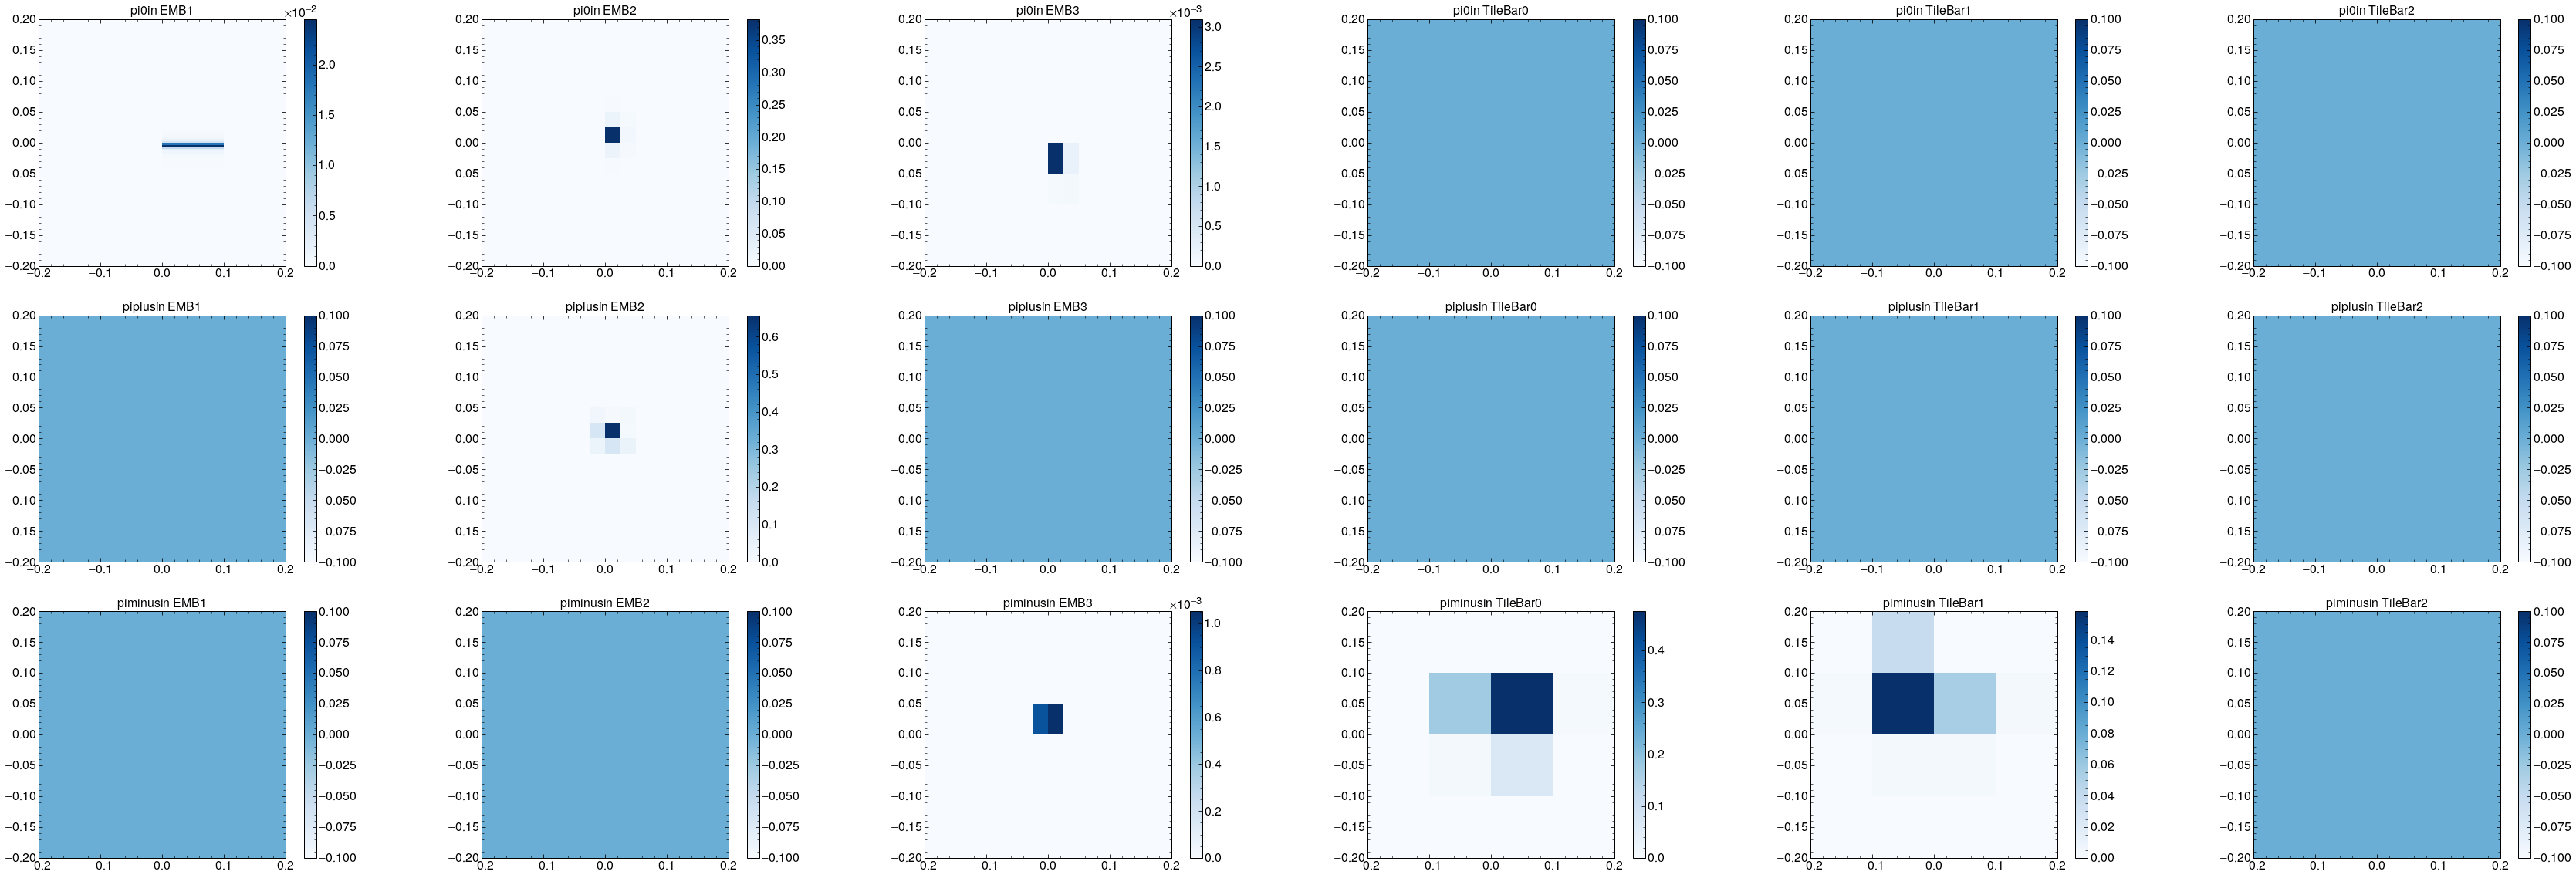

In [8]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 0
for ptype, pcell in pcells.items():
    for layer in layers:
        i = i+1
        plt.subplot(3,6,i)
        plt.imshow(pcell[layer][cluster].reshape(cell_shapes[layer]), extent=[-0.2, 0.2, -0.2, 0.2],
            cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
        plt.colorbar()
        plt.title(ptype+ 'in '+str(layer))
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")

# show the plots
plt.savefig(plotpath+'plots_pi0_plus_minus.pdf')
plt.show()

### Plot a few histograms

In [ ]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig = plt.figure(figsize=(30,20))
fig.patch.set_facecolor('white')

qtys = ['cluster_nCells', 'clusterE', 'clusterEta', 'clusterPhi', 'cluster_EM_PROBABILITY', 'cluster_sumCellE']
qty_labels = ['Cells/Cluster', 'Cluster Energy [GeV]', 'Cluster $\eta$', 'Cluster $\phi$', 'Cluster EMProb', 'Cluster SumCellE']
qty_ranges = [(0,500), (50,200), None, None, None, None]
for i, (qty, label, rng) in enumerate(zip(qtys, qty_labels, qty_ranges)):
    plt.subplot(2,3,i+1)
    for ptype, p in pdata.items():
        plt.hist(p[qty], bins=n_bins, density=True,
                 range=rng, alpha=0.7, label=ptype)
    ampl.set_xlabel(label)
    ampl.set_ylabel("Normalised events")
    plt.legend()

plt.savefig(plotpath+'hist_pi0_plus_minus.pdf')
plt.show()

## Simple feed-forward Neural Network
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

In [ ]:
import tensorflow as tf

gpu_list = ["/gpu:0"] #["/gpu:0","/gpu:1","/gpu:2","/gpu:3"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

In [ ]:
from keras.utils import np_utils
training_dataset = ['pi0','piplus']

# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
for p_index, plabel in enumerate(training_dataset):
    mu.splitFrameTVT(pdata[plabel],trainfrac=0.7)
    pdata[plabel]['label'] = p_index

# merge pi0 and pi+ events
pdata_merged = pd.concat([pdata[ptype] for ptype in training_dataset])
pcells_merged = {
    layer : np.concatenate([pcells[ptype][layer]
                            for ptype in training_dataset])
    for layer in layers
}
plabels = np_utils.to_categorical(pdata_merged['label'],len(training_dataset))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [ ]:
# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        optimizer = Adam(lr=5e-5)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [ ]:
# build the model
models = {}
for layer in layers:
    npix = cell_shapes[layer][0]*cell_shapes[layer][1]
    models[layer] = baseline_nn_model(npix)
    models[layer].summary()

In [ ]:
model_history = {}
model_performance = {}
model_scores = {}
for layer in layers:
    print('On layer ' + layer)
    
    # train+validate model
    model_history[layer] = models[layer].fit(
        pcells_merged[layer][pdata_merged.train], plabels[pdata_merged.train],
        validation_data = (
            pcells_merged[layer][pdata_merged.val], plabels[pdata_merged.val]
        ),
        epochs = 100, batch_size = 200*ngpu, verbose = 2,
    )
    model_history[layer] = model_history[layer].history
    # get overall performance metric
    model_performance[layer] = models[layer].evaluate(
        pcells_merged[layer][pdata_merged.test], plabels[pdata_merged.test],
        verbose = 0,
    )
    
    # get network scores for the dataset
    model_scores[layer] = models[layer].predict(
        pcells_merged[layer]
    )
    
    print('Finished layer ' + layer)
    

In [ ]:
import pickle

for layer in layers:
    print('Saving ' + layer)
    models[layer].save(modelpath+'model_' + layer + '_flat_do20.h5')
    
    with open(modelpath + 'model_' + layer + '_flat_do20.history','wb') as model_history_file:
        pickle.dump(model_history[layer], model_history_file)

In [ ]:
import pickle

#alternate to fitting the model: load a saved model
models = {}
model_history = {}
model_scores = {}
for layer in layers:
    print('Loading ' + layer)
    models[layer] = tf.keras.models.load_model(modelpath+'model_' + layer + '_flat_do20.h5')
    
    # load history object
    with open(modelpath + 'model_' + layer + '_flat_do20.history','rb') as model_history_file:
        model_history[layer] = pickle.load(model_history_file)
    
    # recalculate network scores for the dataset
    model_scores[layer] = models[layer].predict(
        pcells_merged[layer]
    )

In [ ]:
for layer in layers:
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(model_history[layer]['acc'])
    plt.plot(model_history[layer]['val_acc'])
    plt.title('model accuracy for ' + layer)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(model_history[layer]['loss'])
    plt.plot(model_history[layer]['val_loss'])
    plt.title('model loss for ' + layer)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

for layer in layers:
    roc_fpr[layer], roc_tpr[layer], roc_thresh[layer] = roc_curve(
        plabels[pdata_merged.test][:,1],
        model_scores[layer][pdata_merged.test,1],
        drop_intermediate=False,
    )
    roc_auc[layer] = auc(roc_fpr[layer], roc_tpr[layer])
    print('Area under curve for ' + layer + ': ' + str(roc_auc[layer]))

In [ ]:
lc_fpr, lc_tpr, lc_thresh = roc_curve(
    plabels[pdata_merged.test][:,1],
    1-pdata_merged["cluster_EM_PROBABILITY"][pdata_merged.test],
)
lc_auc = auc(lc_fpr, lc_tpr)
print("Area under curve: " + str(lc_auc))

In [ ]:
pu.roc_plot([lc_fpr,roc_fpr['EMB1']],[lc_tpr,roc_tpr['EMB1']],
            figfile=plotpath + 'roc_lc_only.pdf',
            labels=['LC EMProb (area = {:.3f})'.format(lc_auc),
                    'EMB1 (area = {:.3f})'.format(roc_auc['EMB1'])],
            extra_lines=[[[0, 1], [0, 1]]],
            title='Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

In [ ]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(lc_fpr, lc_tpr, label='LC EMProb (area = {:.3f})'.format(lc_auc))
plt.plot(roc_fpr['EMB1'], roc_tpr['EMB1'], label='EMB1 (area = {:.3f})'.format(roc_auc['EMB1']))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
ampl.set_xlabel('False positive rate')
ampl.set_ylabel('True positive rate')
plt.legend(loc='best')
plt.savefig(plotpath + 'roc_lc_only.pdf')
plt.show()

In [ ]:
# old plots for reference

# plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

# fig = plt.figure()
# fig.patch.set_facecolor('white')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
# plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
# plt.legend(loc='best')
# plt.savefig('Plots/roc_lc_emb1_only.pdf')
# plt.show()

In [ ]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_layers.pdf')
plt.show()


## ROC Curve Scans
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

In [ ]:
# a convenience class for creating ROC curve scans
display_digits=2
class roc_var:
    def __init__(self,
                 name, # name of variable as it appears in the root file
                 bins, # endpoints of bins as a list
                 df,   # dataframe to construct subsets from
                 latex='', # optional latex to display variable name with
                 vlist=None, # optional list to append class instance to
                ):
        self.name = name
        self.bins = bins
        
        if(latex == ''):
            self.latex = name
        else:
            self.latex = latex
        
        self.selections = []
        self.labels = []
        for i, point in enumerate(self.bins):
            if(i == 0):
                self.selections.append( df[name]<point )
                self.labels.append(self.latex+'<'+str(round(point,display_digits)))
            else:
                self.selections.append( (df[name]>self.bins[i-1]) & (df[name]<self.bins[i]) )
                self.labels.append(str(round(self.bins[i-1],display_digits))+'<'+self.latex+'<'+str(round(point,display_digits)))
                if(i == len(bins)-1):
                    self.selections.append( df[name]>point )
                    self.labels.append(self.latex+'>'+str(round(point,display_digits)))
        
        if(vlist != None):
            vlist.append(self)
        
    


In [ ]:
def roc_scan(varlist,scan_targets,labels):
    '''
    Creates a set of ROC curve plots by scanning over the specified variables.
    One set is created for each target (neural net score dataset).
    
    varlist: a list of roc_var instances to scan over
    scan_targets: a list of neural net score datasets to use
    labels: a list of target names (strings); must be the same length as scan_targets
    '''
    for target, target_label in zip(scan_targets,labels):
        for v in varlist:
            # prepare matplotlib figure
            plt.cla()
            plt.clf()
            fig = plt.figure()
            fig.patch.set_facecolor('white')
            plt.plot([0, 1], [0, 1], 'k--')

            for binning, label in zip(v.selections,v.labels):
                # first generate ROC curve
                x, y, t = roc_curve(
                    plabels[pdata_merged.test & binning][:,1],
                    target[pdata_merged.test & binning],
                    drop_intermediate=False,
                )
                var_auc = auc(x,y)
                plt.plot(x, y, label=label+' (area = {:.3f})'.format(var_auc))

            plt.title('ROC Scan of '+target_label+' over '+v.latex)
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)
            ampl.set_xlabel('False positive rate')
            ampl.set_ylabel('True positive rate')
            plt.legend()
            plt.savefig(plotpath+'roc_scan_'+target_label+'_'+v.name+'.pdf')
            plt.show()

In [ ]:
# specify variables we are interested in scanning over
varlist = []
cluster_e = roc_var(
    name='clusterE',
    bins=[1,10,50,500],
    df=pdata_merged,
    vlist=varlist,
)

pdata_merged['abs_clusterEta'] = np.abs(pdata_merged.clusterEta)
cluster_eta = roc_var(
    name='abs_clusterEta',
    bins=[0.2,0.4,0.6],
    df=pdata_merged,
    vlist=varlist,
    latex='abs(clusterEta)'
)


In [ ]:
# begin the scan
targets = [model_scores[layer][:,1] for layer in layers]+[1-pdata_merged["cluster_EM_PROBABILITY"]]
labels = layers+['LC']
roc_scan(varlist,targets,labels)
        

## Combination Network
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model_scores_stack = np.column_stack( [model_scores[layer][:,1] for layer in model_scores] )
model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
simpleCombine_history = model_simpleCombine.fit(model_scores_stack[pdata_merged.train], plabels[pdata_merged.train],
                                                validation_data=(model_scores_stack[pdata_merged.val],
                                                                 plabels[pdata_merged.val]),
                                                epochs = 50, batch_size = 200*ngpu, verbose = 2)
simpleCombine_history = simpleCombine_history.history

In [ ]:
import pickle

model_simpleCombine.save(modelpath+"model_simple_do20.h5")
with open(modelpath + 'model_simple_do20.history','wb') as model_history_file:
    pickle.dump(simpleCombine_history, model_history_file)

In [ ]:
import pickle

model_simpleCombine = tf.keras.models.load_model(modelpath+"model_simple_do20.h5")
with open(modelpath + 'model_simple_do20.history','rb') as model_history_file:
    simpleCombine_history = pickle.load(model_history_file)

In [ ]:
pu.make_plot(
    [simpleCombine_history['acc'],simpleCombine_history['val_acc']],
    figfile = plotpath+'accuracy_simpleCombine.pdf',
    xlabel = 'epoch', ylabel = 'accuracy',
    x_log = False, y_log = False,
    labels = ['train','test'],
    title = 'Model accuracy for simple combination',
)

# summarize history for loss
pu.make_plot(
    [simpleCombine_history['loss'],simpleCombine_history['val_loss']],
    figfile = plotpath+'loss_simpleCombine.pdf',
    xlabel = 'epoch', ylabel = 'loss',
    x_log = False, y_log = False,
    labels = ['train','test'],
    title = 'Model loss for simple combination',
)

In [ ]:
from sklearn.metrics import roc_curve, auc

simpleCombine_score = model_simpleCombine.predict(model_scores_stack)
simpleCombine_fpr, simpleCombine_tpr, simpleCombine_thresh = roc_curve(
    plabels[pdata_merged.test,1], simpleCombine_score[pdata_merged.test,1]
)
simpleCombine_auc = auc(simpleCombine_fpr, simpleCombine_tpr)
print(simpleCombine_auc)

In [ ]:
pu.roc_plot(
    [simpleCombine_fpr,lc_fpr]+[roc_fpr[layer] for layer in layers],
    [simpleCombine_tpr,lc_tpr]+[roc_tpr[layer] for layer in layers],
    figfile = plotpath+'roc_simpleCombine.pdf',
    extra_lines=[[[0, 1], [0, 1]]], labels=[
        'simpleCombine (area = {:.3f})'.format(simpleCombine_auc),
        'LC EMProb (area = {:.3f})'.format(lc_auc),
    ]+[layer+' (area = {:.3f})'.format(roc_auc[layer]) for layer in layers],
    title='Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

pu.roc_plot(
    [simpleCombine_fpr,lc_fpr]+[roc_fpr[layer] for layer in layers],
    [simpleCombine_tpr,lc_tpr]+[roc_tpr[layer] for layer in layers],
    figfile = plotpath+'roc_simpleCombine.pdf',
    x_max=0.25, y_min=0.6,
    extra_lines=[[[0, 1], [0, 1]]], labels=[
        'simpleCombine (area = {:.3f})'.format(simpleCombine_auc),
        'LC EMProb (area = {:.3f})'.format(lc_auc),
    ]+[layer+' (area = {:.3f})'.format(roc_auc[layer]) for layer in layers],
    title='Simple NN ROC curve: zoomed in at top left')

In [ ]:
roc_scan(varlist,[simpleCombine_score[:,1]],['simpleCombine'])

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [ ]:
with strategy.scope():
    
    model_combine = Sequential()
    
    inputs = [
        Input(
            shape=(cell_shapes[layer][0]*cell_shapes[layer][1]),
            name=layer
        )
        for layer in layers
    ]
    
    combine_inputs = []
    for x, layer in zip(inputs, layers):
        input_shape = cell_shapes[layer][0]*cell_shapes[layer][1]
        x_condensed = Dense(input_shape, activation='relu')(x)
        x_condensed = Dropout(0.2)(x_condensed)
        x_condensed = Dense(input_shape/2, activation='relu')(x_condensed)
        x_condensed = Dropout(0.2)(x_condensed)
        x_condensed = Dense(input_shape/4, activation='relu')(x_condensed)
        x_condensed = Dropout(0.2)(x_condensed)
        combine_inputs.append(x_condensed)
        
    combine_output = concatenate([x for x in combine_inputs])
    combine_output = Dense(100, activation='relu')(combine_output)
    combine_output = Dropout(0.2)(combine_output)
    combine_output = Dense(50, activation='relu')(combine_output)
    combine_output = Dropout(0.2)(combine_output)
    combine_output = Dense(2, activation='softmax')(combine_output)
    
    model_combine = Model(inputs=inputs, outputs=[combine_output])
    model_combine.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=5e-5),
        metrics=['acc']
    )

In [ ]:
combine_history = model_combine.fit(
    [pcells_merged[layer][pdata_merged.train] for layer in layers],
    [plabels[pdata_merged.train]],
    validation_data=(
        [pcells_merged[layer][pdata_merged.val] for layer in layers],
        [plabels[pdata_merged.val]]
    ),
    epochs=100,
    batch_size=200*ngpu,
    verbose=2
)
combine_history = combine_history.history

In [ ]:
import pickle

model_combine.save(modelpath+"model_deep_do20.h5")
with open(modelpath + 'model_deep_do20.history','wb') as model_history_file:
    pickle.dump(combine_history, model_history_file)

In [ ]:
import pickle

model_combine = tf.keras.models.load_model(modelpath+"model_deep_do20.h5")
with open(modelpath + 'model_deep_do20.history','rb') as model_history_file:
    combine_history = pickle.load(model_history_file)

In [ ]:
pu.make_plot(
    [combine_history['acc'],combine_history['val_acc']],
    figfile = plotpath+'accuracy_deepCombine.pdf',
    xlabel = 'epoch', ylabel = 'accuracy',
    x_log = False, y_log = False,
    labels = ['train','test'],
    title = 'Model accuracy for deep combination',
)

# summarize history for loss
pu.make_plot(
    [combine_history['loss'],combine_history['val_loss']],
    figfile = plotpath+'loss_deepCombine.pdf',
    xlabel = 'epoch', ylabel = 'loss',
    x_log = False, y_log = False,
    labels = ['train','test'],
    title = 'Model loss for deep combination',
)

In [ ]:
from sklearn.metrics import roc_curve, auc

combine_score = model_combine.predict(
    [ pcells_merged[layer] for layer in layers ]
)
combine_fpr, combine_tpr, combine_thresh = roc_curve(
    plabels[pdata_merged.test][:,1],
    combine_score[pdata_merged.test,1]
)
combine_auc = auc(combine_fpr, combine_tpr)
print("Area under curve: {}".format(combine_auc))

In [ ]:
pu.roc_plot(
    [simpleCombine_fpr,combine_fpr,lc_fpr,roc_fpr['EMB1']],
    [simpleCombine_tpr,combine_tpr,lc_tpr,roc_tpr['EMB1']],
    figfile=plotpath + 'roc_combine.pdf',
    labels=[
        'simpleCombine (area = {:.3f})'.format(simpleCombine_auc),
        'combine (area = {:.3f})'.format(combine_auc),
        'LC EMProb (area = {:.3f})'.format(lc_auc),
        'EMB1 (area = {:.3f})'.format(roc_auc['EMB1'])
    ],
    extra_lines=[[[0, 1], [0, 1]]],
    title='ROC curve comparison: classification of $\pi^+$ vs. $\pi^0$'
)

pu.roc_plot(
    [simpleCombine_fpr,combine_fpr,lc_fpr,roc_fpr['EMB1']],
    [simpleCombine_tpr,combine_tpr,lc_tpr,roc_tpr['EMB1']],
    figfile=plotpath + 'roc_combine_zoom.pdf',
    x_max=0.25, y_min=0.6, y_max=1,
    labels=[
        'simpleCombine (area = {:.3f})'.format(simpleCombine_auc),
        'combine (area = {:.3f})'.format(combine_auc),
        'LC EMProb (area = {:.3f})'.format(lc_auc),
        'EMB1 (area = {:.3f})'.format(roc_auc['EMB1'])
    ],
    extra_lines=[[[0, 1], [0, 1]]],
    title='ROC curve comparison: zoomed in at top left'
)

In [ ]:
roc_scan(
    varlist,
    [combine_score[:,1]],
    ['deep combine']
)

In [ ]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.yscale('log')
plt.plot(tpr_lc, 1/fpr_lc, label='LC EMProb')
for layer_i, layer_name in enumerate(layers):
    plt.plot(tpr_flat_nn[layer_i], 1/fpr_flat_nn[layer_i], label='{}'.format(layer_name))
plt.plot(tpr_simpleCombine, 1/fpr_simpleCombine, label='Layers Simple')
plt.plot(tpr_combine, 1/fpr_combine, label='Layers Deep')
plt.legend(loc='best')
plt.xlabel('True Efficiency')
plt.ylabel('Bkgd Rejection')
plt.savefig(plotpath+'roc_reg_combine2_layers.pdf')
plt.show()


In [ ]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

In [ ]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_EM_PROBABILITY'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('Plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('Plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('Plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('Plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

## Convolutional Neural Network
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

In [ ]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
    X = np.append(data_0[layer], data_1[layer], axis=0)
    X = X.reshape(X.shape[0], 1, len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)
    return X, Y, num_pixels

In [ ]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import backend as K
# K.image_data_format('th')
K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)

In [ ]:
# split up into training and test datasets, using functions
test_size = 24000
validation_size = 24000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_cnn[layer_i], y_cnn[layer_i], test_size, validation_size)


In [ ]:
# define a simple convolutional model
def baseline_ccn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
# define a simple convolutional model

filters = [(2,4), (4,4), (4,4), (2,2), (2,2), (2,1)]

def baseline_cnn_model_layers(layer_i):
    # create model
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(32, filters[layer_i], input_shape=(1,len_phi[layer_i],len_eta[layer_i]), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [ ]:
model_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print(layer_name)
    print(len_phi[layer_i])
    print(len_eta[layer_i])
    model_cnn_base_layers[layer_i] = baseline_cnn_model_layers(layer_i)
    model_cnn_base_layers[layer_i].summary()

In [ ]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [ ]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

In [ ]:
history_cnn_base_layers = {}
for layer_i, layer_name in enumerate(layers):
    print('On layer {}'.format(layer_name))
    history_cnn_base_layers[layer_i] = model_cnn_base_layers[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=200, batch_size=200*ngpu, verbose=2)


In [ ]:
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_cnn_base_layers[layer_i].history['acc'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_cnn_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_cnn_base_layers[layer_i].history['loss'])
    plt.plot(history_cnn_base_layers[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_cnn_{}.pdf'.format(layer_name))
    plt.show()

In [ ]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=40, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_baseline_pred = model_cnn_base.predict(X_te)
fpr_baseline, tpr_baseline, thres_baseline = roc_curve(y_te_onehot[:,1], y_baseline_pred[:,1])
auc_baseline = auc(fpr_baseline, tpr_baseline)
print("Area under curve: {}".format(auc_baseline))

y_large_pred = model_cnn_large.predict(X_te)
fpr_large, tpr_large, thres_large = roc_curve(y_te_onehot[:,1], y_large_pred[:,1])
auc_large = auc(fpr_large, tpr_large)
print("Area under curve: {}".format(auc_large))

In [ ]:
y_baseline_layers_pred = {}
fpr_baseline_layers = {}
tpr_baseline_layers = {}
thres_baseline_layers = {}
auc_baseline_layers = {}
for layer_i, layer_name in enumerate(layers):
    y_baseline_layers_pred[layer_i] = model_cnn_base_layers[layer_i].predict(x_cnn_te[layer_i])
    fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], thres_baseline_layers[layer_i] = roc_curve(y_cnn_te_onehot[layer_i][:,1], y_baseline_layers_pred[layer_i][:,1])
    auc_baseline_layers[layer_i] = auc(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i])
    print("Area under curve: {}".format(auc_baseline_layers[layer_i]))
#     y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
#     fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
#     auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
#     print("Area under curve: {}".format(auc_flat_nn[layer_i]))


In [ ]:
for layer_i, layer_name in enumerate(layers):
    print('Saving {}'.format(layer_name))
    model_cnn_base_layers[layer_i].save(modelpath+"model_{}_cnn_base.h5".format(layer_name))

In [ ]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.plot(fpr_baseline, tpr_baseline, label='{} (area = {:.3f})'.format("EMB2 CNN Baseline", auc_baseline))
plt.plot(fpr_large, tpr_large, label='{} (area = {:.3f})'.format("EMB2 CNN Large", auc_large))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_cnn.pdf')
plt.show()

In [ ]:
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()


    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    # Zoom in view of the upper left corner.
    plt.xlim(0, 0.25)
    plt.ylim(0.6, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
    plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
    plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} Flat (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
    plt.plot(fpr_baseline_layers[layer_i], tpr_baseline_layers[layer_i], label='{} CNN (area = {:.3f})'.format(layer_name, auc_baseline_layers[layer_i]))
    # ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.savefig('Plots/roc_zoom_layers_cnn_{}.pdf'.format(layer_name))
    plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print X0.shape
print X1.shape
print X2.shape
print y.shape

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [ ]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

In [ ]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [ ]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

In [ ]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

## Correlation Plots
<div style="text-align: right"> <a href="#Image-Classification-of-ATLAS-Calorimeter-Topo-Clusters-Rewrite">Top</a> </div>

In [ ]:
# get network scores
combine_score = {}
for ptype, pcell in pcells.items():
    combine_score[ptype] = model_combine.predict(
        [ pcell[layer] for layer in layers ]
    )
combine_score['piplus'][:,0] = 1 - combine_score['piplus'][:,0]
combine_score['piminus'][:,0] = 1 - combine_score['piminus'][:,0]

In [ ]:
import scipy
cor = {}
test_subset = {
    'pi0': pdata['pi0'].test,
    'piplus': pdata['piplus'].test,
    'piminus': [True for i in range(len(pdata['piminus']))]
}

# calculate inclusive correlations
for ptype, pcell in pcells.items():
    cor[ptype] = {}
    for layer in layers:
        cor[ptype][layer] = np.zeros(shape=(pcell[layer].shape[1],2))
        for i in range(pcell[layer].shape[1]):
            cor[ptype][layer][i] = scipy.stats.pearsonr(
                pcell[layer][test_subset[ptype]][:,i],
                combine_score[ptype][test_subset[ptype]][:,0]
            )
    

In [ ]:
# colourmap generator
def get_cmap(xmin,xmax):
    if(xmin > 0):
        # all positive
        cdict = {
            'red': ((0, 1, 1),
                   (1, 0, 0)),
            'green': ((0, 1, 1),
                      (1, 0, 0)),
            'blue': ((0, 1, 1),
                     (1, 1, 1))
        }
    elif(xmax < 0):
        # all negative
        cdict = {
            'red': ((0, 1, 1),
                    (1, 1, 1)),
            'green': ((0, 0, 0),
                     (1, 1, 1)),
            'blue': ((0, 0, 0),
                     (1, 1, 1))
        }
    else:
        # two-sided
        xrange = xmax - xmin
        white_point = -xmin/xrange
        
        cdict = {
            'red': ((0.0, 1.0, 1.0),
                    (white_point, 1.0, 1.0),
                    (1.0, 0.0, 0.0)),
         
            'green': ((0.0, 0.0, 0.0),
                      (white_point, 1.0, 1.0),
                      (1.0, 0.0, 0.0)),
             
            'blue': ((0.0, 0.0, 0.0),
                     (white_point, 1.0, 1.0),
                     (1.0, 1.0, 1.0)),
        }
    return mpl.colors.LinearSegmentedColormap('rwb', cdict, 1024)

In [ ]:
for ptype in cor:
    for layer in layers:
        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        data = cor[ptype][layer][:,0].reshape(cell_shapes[layer])
        data[np.isnan(data)] = 0
        xmin = np.amin(data)
        xmax = np.amax(data)
        plt.imshow(data, extent=[-0.2, 0.2, -0.2, 0.2],
                   norm=mpl.colors.SymLogNorm(linthresh=0.002, linscale=1,
                       vmin=-1.0, vmax=1.0, base=10),
                   cmap='RdBu', origin='lower',
                   interpolation='nearest')
#         plt.title('DNN Correlation for '+ptype+' events in '+layer)
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
        fig.axes[0].text(-0.18, 0.135, 'DNN Correlation for '+pi_latex[ptype]+' events')
        fig.axes[0].text(-0.18, 0.105, layer)
        cbar = plt.colorbar()
        cbar.set_label('Pearson correlation', rotation=270, labelpad=20)
        plt.savefig(plotpath+'cor_'+ptype+'_'+layer+'.pdf')
        plt.show()

In [ ]:
import scipy
energy_bins = [0, 1, 5, 20, 100, 500]
cor_binned = {}
test_subset = {
    'pi0': pdata['pi0'].test,
    'piplus': pdata['piplus'].test,
    'piminus': [True for i in range(len(pdata['piminus']))]
}

# calculate and plot energy-binned correlations
for ptype, pcell in pcells.items():
    cor_binned[ptype] = {}
    for layer in layers:
        cor_binned[ptype][layer] = []
        for ibin in range(len(energy_bins)):
            if( ibin == len(energy_bins)-1 ):
                sel = pdata[ptype]['clusterE'] > energy_bins[ibin]
                label = 'Energy / GeV > '+str(energy_bins[ibin])
            else:        
                sel = (pdata[ptype]['clusterE'] > energy_bins[ibin]) & (pdata[ptype]['clusterE'] > energy_bins[ibin+1])
                label = str(energy_bins[ibin])+' < Energy / GeV < '+str(energy_bins[ibin+1])
            
            cor_binned[ptype][layer].append(
                np.zeros(shape=(pcell[layer].shape[1],2))
            )
            for pixel in range(pcell[layer].shape[1]):
                cor_binned[ptype][layer][ibin][pixel] = scipy.stats.pearsonr(
                    pcell[layer][test_subset[ptype] & sel][:,pixel],
                    combine_score[ptype][test_subset[ptype] & sel][:,0]
                )
            
            plt.cla(); plt.clf()
            fig = plt.figure()
            fig.patch.set_facecolor('white')
            
            data = cor_binned[ptype][layer][ibin][:,0].reshape(cell_shapes[layer])
            data[np.isnan(data)] = 0
            xmin = np.amin(data)
            xmax = np.amax(data)
            plt.imshow(data,
                       extent=[-0.2, 0.2, -0.2, 0.2],
                       norm=mpl.colors.SymLogNorm(linthresh=0.002, linscale=1,
                       vmin=-1.0, vmax=1.0, base=10),
                       cmap='RdBu', origin='lower',
                       interpolation='nearest')

#             plt.title('DNN Correlation for '+ptype+' events in '+layer+', '+label)
            ampl.set_xlabel("$\Delta\phi$")
            ampl.set_ylabel("$\Delta\eta$")
            ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
            fig.axes[0].text(-0.18, 0.135, 'DNN Correlation for '+pi_latex[ptype]+' events')
            fig.axes[0].text(-0.18, 0.105, layer+', '+label)
            cbar = plt.colorbar()
            cbar.set_label('Pearson correlation', rotation=270, labelpad=20)
            plt.savefig(plotpath+'cor_'+ptype+'_'+layer+'_clusterE'+str(ibin)+'.pdf')
            plt.show()